In [87]:
import pandas as pd
import numpy as np
import json
import folium
from datetime import datetime, timedelta
import os
import seaborn as sns
import matplotlib.pyplot as plt

import yaml

In [88]:
from data_cleaning.json_manipulation import load_json, trim_json_to_locations, gather_bajs_locations, get_bikes_in_stations, calculate_bike_changes, create_changes_columns, create_population_columns
from visualization.station_map import populate_map_with_stations
from visualization.individual_station_plots import plot_hourly_changes_bar, plot_weekday_bar, stringify_plot, combined_plot_daily_weekly, station_population_boxplots
from data_cleaning.data_wrangling import create_hourly_df, create_weekday_df, get_population_extremes

In [89]:
config = yaml.safe_load(open("../config.YAML"))

In [90]:
with open("../data/test_JSON_data/bajs_10-11-2025_15-11-31.json") as json_data:
    day_one = json.load(json_data)
    json_data.close()

In [91]:
day_one

{'countries': [{'lat': 45.8049,
   'lng': 15.9467,
   'zoom': 10,
   'name': 'Bajs Zagreb (Croatia)',
   'hotline': '0038515494477',
   'domain': 'hd',
   'language': 'hr',
   'email': 'bajs@zagreb.hr',
   'timezone': 'Europe/Berlin',
   'currency': 'EUR',
   'country_calling_code': '+385',
   'system_operator_address': 'Sustav javnih bicikala d.o.o., Prisavlje 2, 10000 Zagreb',
   'country': 'HR',
   'country_name': 'Croatia',
   'terms': 'https://bajs.zagreb.hr/hr/uvjetikoristenja/',
   'policy': 'https://bajs.zagreb.hr/hr/pravila-privatnosti/',
   'website': 'https://bajs.zagreb.hr',
   'show_bike_types': False,
   'show_bike_type_groups': False,
   'show_free_racks': False,
   'booked_bikes': 0,
   'set_point_bikes': 2000,
   'available_bikes': 1812,
   'capped_available_bikes': False,
   'no_registration': False,
   'pricing': 'https://bajs.zagreb.hr/hr/',
   'vat': '25',
   'faq_url': 'https://bajs.zagreb.hr',
   'store_uri_android': 'https://play.google.com/store/apps/details?id

In [92]:
trim_json_to_locations(day_one)

[{'uid': 556632908,
  'lat': 45.825299,
  'lng': 16.109747,
  'bike': False,
  'name': 'AUTOBUSNI TERMINAL SESVETE',
  'address': None,
  'spot': True,
  'number': 21200,
  'booked_bikes': 0,
  'bikes': 5,
  'bikes_available_to_rent': 5,
  'active_place': 1,
  'bike_racks': 8,
  'free_racks': 3,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800463', '800020', '801638', '801088', '801072'],
  'bike_types': {'196': 4, '409': 1},
  'place_type': '0',
  'rack_locks': False},
 {'uid': 556633495,
  'lat': 45.842797,
  'lng': 15.975421,
  'bike': False,
  'name': 'MIHALJEVAC OKRETIŠTE',
  'address': None,
  'spot': True,
  'number': 21201,
  'booked_bikes': 0,
  'bikes': 11,
  'bikes_available_to_rent': 11,
  'active_place': 1,
  'bike_racks': 12,
  'free_racks': 1,
  'special_racks': 0,
  'free_special_racks': 0,
  'maintenance': False,
  'terminal_type': 'free',
  'bike_numbers': ['800480',
   '800247',
   '800185',
 

In [93]:
locations = gather_bajs_locations(trim_json_to_locations(day_one))
locations.head()

,uid,name,lat,lng,no_racks
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20


In [94]:
locations.shape
# 165 different stations in Zagreb

(165, 5)

Thunderforest.Neighbourhood
OSMBright
Esri.WorldTopoMap
CartoDB.Voyager

In [95]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [96]:
circles = populate_map_with_stations(m, locations)
_ = [circ.add_to(m) for circ in circles]


In [97]:
m

## Individual bikes at individual times

In [98]:
first_dt = datetime.strptime("2025/11/10 15:11:31",
    "%Y/%m/%d %H:%M:%S")

first_dt

datetime.datetime(2025, 11, 10, 15, 11, 31)

In [99]:
time1 = get_bikes_in_stations(time = first_dt,
    loc_list = trim_json_to_locations(day_one))

time1.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]"
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005..."
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155..."
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]"
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099..."


In [100]:
# For testing purposes, we'll use this data as a second timepoint even though it's been more than a day
with open("../data/test_JSON_data/bajs_12-11-2025_09-30-11.json") as json_data:
    day_two = json.load(json_data)
    json_data.close()

In [101]:
second_dt = datetime.strptime("2025/11/10 16:30:00",
    "%Y/%m/%d %H:%M:%S")

time2 = get_bikes_in_stations(time = second_dt,
    loc_list = trim_json_to_locations(day_two))

time2.sort_values("uid").head()

,uid,time,bikes_at_station
0,556632908,2025-11-10 16:30:00,"[800479, 800463, 800282, 801088]"
1,556633495,2025-11-10 16:30:00,"[800480, 800185, 800052, 801489, 801321]"
2,556634009,2025-11-10 16:30:00,"[800274, 801882, 801360, 801296, 801022]"
3,556637365,2025-11-10 16:30:00,"[800344, 800033, 801920, 801915, 801881, 80164..."
4,556689563,2025-11-10 16:30:00,"[800485, 800329, 800233, 800230, 800223, 80019..."


In [102]:
more_times = pd.concat([time1, time2])
# for each uid-time, what is the closest observed time before the one in this row?
more_times["lag1_time"] = more_times.groupby(["uid"])["time"].shift(1)

more_times

previous_bikes = more_times.merge(more_times.drop(["lag1_time"], axis = 1), # so we don't get this as an additional column
    how = "left",
    left_on = ["uid", "lag1_time"],
    right_on = ["uid", "time"],
    suffixes = (None, "_lag1")).drop(
        ["time_lag1"], axis = 1
    )



previous_bikes

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1
0,556632908,2025-11-10 15:11:31,"[800463, 800020, 801638, 801088, 801072]",NaT,NaN
1,556633495,2025-11-10 15:11:31,"[800480, 800247, 800185, 800183, 800106, 80005...",NaT,NaN
2,556634009,2025-11-10 15:11:31,"[800220, 800201, 800129, 800079, 801644, 80155...",NaT,NaN
3,556637365,2025-11-10 15:11:31,"[801920, 801915, 800748, 800640, 800625]",NaT,NaN
4,556689563,2025-11-10 15:11:31,"[801846, 801835, 801548, 801542, 801000, 80099...",NaT,NaN
...,...,...,...,...,...
326,585913527,2025-11-10 16:30:00,"[800278, 800101, 801656, 801228, 801046, 80077...",2025-11-10 15:11:31,[]
327,585913605,2025-11-10 16:30:00,"[801717, 801191, 801157, 800603, 800601, 800517]",2025-11-10 15:11:31,[801963]
328,585913702,2025-11-10 16:30:00,"[800347, 800115, 801866, 801826, 801795, 80166...",2025-11-10 15:11:31,"[800293, 800219, 800191, 800068, 801907, 80175..."
329,586256300,2025-11-10 16:30:00,"[800144, 801889, 801867, 801457, 801066, 80095...",2025-11-10 15:11:31,"[800318, 800144, 801889, 801867, 801169, 80116..."


In [103]:
calculate_bike_changes(previous_bikes["bikes_at_station"], previous_bikes["bikes_at_station_lag1"])

{'changes': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     7.0
 328    31.0
 329     5.0
 330     5.0
 Length: 331, dtype: float64,
 'incoming': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     0.0
 327     1.0
 328    15.0
 329     3.0
 330     0.0
 Length: 331, dtype: float64,
 'outgoing': 0       NaN
 1       NaN
 2       NaN
 3       NaN
 4       NaN
        ... 
 326     8.0
 327     6.0
 328    16.0
 329     2.0
 330     5.0
 Length: 331, dtype: float64}

## Load all data from folder and calculate changes

In [104]:
raw_files_directory = "../data/" + config["data"]["raw_json_folder"]

raw_files = os.listdir(raw_files_directory)
raw_files

['bajs_01-12-2025_00-02-18.json',
 'bajs_01-12-2025_01-10-49.json',
 'bajs_01-12-2025_02-00-54.json',
 'bajs_01-12-2025_03-11-25.json',
 'bajs_01-12-2025_04-02-31.json',
 'bajs_01-12-2025_05-02-24.json',
 'bajs_01-12-2025_06-10-47.json',
 'bajs_01-12-2025_07-07-39.json',
 'bajs_01-12-2025_08-04-09.json',
 'bajs_01-12-2025_09-06-59.json',
 'bajs_01-12-2025_10-04-53.json',
 'bajs_01-12-2025_11-14-32.json',
 'bajs_01-12-2025_12-02-59.json',
 'bajs_01-12-2025_13-06-45.json',
 'bajs_01-12-2025_14-01-40.json',
 'bajs_01-12-2025_15-10-12.json',
 'bajs_01-12-2025_16-09-08.json',
 'bajs_01-12-2025_17-11-41.json',
 'bajs_01-12-2025_18-05-10.json',
 'bajs_01-12-2025_19-01-57.json',
 'bajs_01-12-2025_20-13-56.json',
 'bajs_01-12-2025_21-08-02.json',
 'bajs_01-12-2025_22-08-07.json',
 'bajs_01-12-2025_23-05-28.json',
 'bajs_02-12-2025_00-09-59.json',
 'bajs_02-12-2025_01-07-10.json',
 'bajs_02-12-2025_02-10-22.json',
 'bajs_02-12-2025_03-04-38.json',
 'bajs_02-12-2025_04-13-08.json',
 'bajs_02-12-2

In [105]:
raw_files[0][5:-5]

'01-12-2025_00-02-18'

In [106]:
#TODO - extracting from first to last number instead of absolute position?

datetime.strptime(raw_files[0][5:-5], "%d-%m-%Y_%H-%M-%S")

datetime.datetime(2025, 12, 1, 0, 2, 18)

In [107]:
scraped_datetimes = [datetime.strptime(filename[5:-5], "%d-%m-%Y_%H-%M-%S") for filename in raw_files]
scraped_datetimes

[datetime.datetime(2025, 12, 1, 0, 2, 18),
 datetime.datetime(2025, 12, 1, 1, 10, 49),
 datetime.datetime(2025, 12, 1, 2, 0, 54),
 datetime.datetime(2025, 12, 1, 3, 11, 25),
 datetime.datetime(2025, 12, 1, 4, 2, 31),
 datetime.datetime(2025, 12, 1, 5, 2, 24),
 datetime.datetime(2025, 12, 1, 6, 10, 47),
 datetime.datetime(2025, 12, 1, 7, 7, 39),
 datetime.datetime(2025, 12, 1, 8, 4, 9),
 datetime.datetime(2025, 12, 1, 9, 6, 59),
 datetime.datetime(2025, 12, 1, 10, 4, 53),
 datetime.datetime(2025, 12, 1, 11, 14, 32),
 datetime.datetime(2025, 12, 1, 12, 2, 59),
 datetime.datetime(2025, 12, 1, 13, 6, 45),
 datetime.datetime(2025, 12, 1, 14, 1, 40),
 datetime.datetime(2025, 12, 1, 15, 10, 12),
 datetime.datetime(2025, 12, 1, 16, 9, 8),
 datetime.datetime(2025, 12, 1, 17, 11, 41),
 datetime.datetime(2025, 12, 1, 18, 5, 10),
 datetime.datetime(2025, 12, 1, 19, 1, 57),
 datetime.datetime(2025, 12, 1, 20, 13, 56),
 datetime.datetime(2025, 12, 1, 21, 8, 2),
 datetime.datetime(2025, 12, 1, 22, 8,

**IMPORTANT**  
The scraper times need to be adjusted up by an hour to match the local times!

In [108]:
scraped_datetimes = [date + timedelta(hours = 1) for date in scraped_datetimes]
scraped_datetimes

[datetime.datetime(2025, 12, 1, 1, 2, 18),
 datetime.datetime(2025, 12, 1, 2, 10, 49),
 datetime.datetime(2025, 12, 1, 3, 0, 54),
 datetime.datetime(2025, 12, 1, 4, 11, 25),
 datetime.datetime(2025, 12, 1, 5, 2, 31),
 datetime.datetime(2025, 12, 1, 6, 2, 24),
 datetime.datetime(2025, 12, 1, 7, 10, 47),
 datetime.datetime(2025, 12, 1, 8, 7, 39),
 datetime.datetime(2025, 12, 1, 9, 4, 9),
 datetime.datetime(2025, 12, 1, 10, 6, 59),
 datetime.datetime(2025, 12, 1, 11, 4, 53),
 datetime.datetime(2025, 12, 1, 12, 14, 32),
 datetime.datetime(2025, 12, 1, 13, 2, 59),
 datetime.datetime(2025, 12, 1, 14, 6, 45),
 datetime.datetime(2025, 12, 1, 15, 1, 40),
 datetime.datetime(2025, 12, 1, 16, 10, 12),
 datetime.datetime(2025, 12, 1, 17, 9, 8),
 datetime.datetime(2025, 12, 1, 18, 11, 41),
 datetime.datetime(2025, 12, 1, 19, 5, 10),
 datetime.datetime(2025, 12, 1, 20, 1, 57),
 datetime.datetime(2025, 12, 1, 21, 13, 56),
 datetime.datetime(2025, 12, 1, 22, 8, 2),
 datetime.datetime(2025, 12, 1, 23, 8

In [109]:
data_timepoints = [
    trim_json_to_locations(load_json(raw_files_directory + "/" + json_file))
    for json_file
    in raw_files
]

len(data_timepoints)

792

In [174]:
max(scraped_datetimes)

datetime.datetime(2025, 12, 13, 23, 12, 20)

In [182]:
latest_dt = scraped_datetimes.index(max(scraped_datetimes))
latest_dt

383

In [183]:
scraped_datetimes[latest_dt]

datetime.datetime(2025, 12, 13, 23, 12, 20)

In [184]:
# Locations on most up-to-date info
locations = gather_bajs_locations(data_timepoints[latest_dt])

In [111]:
bike_data = None

for i in range(len(data_timepoints)):
    timepoint_bikes = get_bikes_in_stations(time = scraped_datetimes[i],
        loc_list = data_timepoints[i])

    if i == 0: 
        bike_data = timepoint_bikes
    else:
        bike_data = pd.concat([bike_data, timepoint_bikes])

bike_data

,uid,time,bikes_at_station
0,556632908,2025-12-01 01:02:18,"[800479, 800463, 800450, 800191, 801402, 80115..."
1,556633495,2025-12-01 01:02:18,"[800480, 800307, 800272, 800220, 801801, 80145..."
2,556634009,2025-12-01 01:02:18,"[800375, 800141, 800074, 800056, 800012, 80191..."
3,556637365,2025-12-01 01:02:18,"[800383, 800382, 800305, 800271, 800226, 80020..."
4,556689563,2025-12-01 01:02:18,"[800347, 800187, 800092, 801950, 801641, 80116..."
...,...,...,...
164,585913605,2025-12-01 00:05:44,"[800243, 801928, 801851, 801838, 801814, 80166..."
165,585913702,2025-12-01 00:05:44,"[800405, 800084, 801909, 801758, 800752]"
166,586256300,2025-12-01 00:05:44,"[800499, 800183, 801889, 801022, 800577]"
167,586273004,2025-12-01 00:05:44,"[800495, 800420, 801924, 801860, 801790, 80166..."


In [112]:
bike_data = create_changes_columns(bike_data)

    # Drop the rows that have undefined changes - those belong to very first
    # datapoints, with no points before them so changes can't be calculated
    # Removing those will keep them from distorting e.g. means (they still count as n for dividing sums)
bike_data = bike_data.query("changes.notna()")
bike_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
165,556632908,2025-11-11 01:15:08,"[800463, 800020, 801638, 801088, 800886]",2025-11-11 00:01:43,"[800463, 800020, 801638, 801088, 800886]",0.0,0.0,0.0
166,556633495,2025-11-11 01:15:08,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-11 00:01:43,"[800480, 800247, 800185, 800183, 800106, 80005...",0.0,0.0,0.0
167,556634009,2025-11-11 01:15:08,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-11 00:01:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2.0,0.0,2.0
168,556637365,2025-11-11 01:15:08,"[800428, 801920, 801915, 801881, 801745, 80164...",2025-11-11 00:01:43,"[800428, 801920, 801915, 801881, 801745, 80164...",0.0,0.0,0.0
169,556689563,2025-11-11 01:15:08,"[800223, 801846, 801666, 801548, 801347, 80128...",2025-11-11 00:01:43,"[801846, 801666, 801548, 801347, 801283, 80100...",1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
134509,591300427,2025-12-13 23:12:20,"[801737, 801702, 801263, 801185, 801175, 80094...",2025-12-13 22:12:26,"[801737, 801263, 801185, 801175, 800946, 800859]",1.0,1.0,0.0
134510,591300997,2025-12-13 23:12:20,"[801492, 801082, 801047, 800626]",2025-12-13 22:12:26,"[801492, 801082, 801047, 800626]",0.0,0.0,0.0
134511,591301317,2025-12-13 23:12:20,"[800294, 800082, 800066, 801985, 801594, 80157...",2025-12-13 22:12:26,"[800368, 800294, 800082, 800066, 801985, 80159...",2.0,0.0,2.0
134512,591302073,2025-12-13 23:12:20,"[800379, 800303, 801270, 801239, 801125, 80111...",2025-12-13 22:12:26,"[800379, 800303, 801270, 801239, 801125, 80111...",1.0,1.0,0.0


## Total changes on map

In [113]:
bike_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing
165,556632908,2025-11-11 01:15:08,"[800463, 800020, 801638, 801088, 800886]",2025-11-11 00:01:43,"[800463, 800020, 801638, 801088, 800886]",0.0,0.0,0.0
166,556633495,2025-11-11 01:15:08,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-11 00:01:43,"[800480, 800247, 800185, 800183, 800106, 80005...",0.0,0.0,0.0
167,556634009,2025-11-11 01:15:08,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-11 00:01:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2.0,0.0,2.0
168,556637365,2025-11-11 01:15:08,"[800428, 801920, 801915, 801881, 801745, 80164...",2025-11-11 00:01:43,"[800428, 801920, 801915, 801881, 801745, 80164...",0.0,0.0,0.0
169,556689563,2025-11-11 01:15:08,"[800223, 801846, 801666, 801548, 801347, 80128...",2025-11-11 00:01:43,"[801846, 801666, 801548, 801347, 801283, 80100...",1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
134509,591300427,2025-12-13 23:12:20,"[801737, 801702, 801263, 801185, 801175, 80094...",2025-12-13 22:12:26,"[801737, 801263, 801185, 801175, 800946, 800859]",1.0,1.0,0.0
134510,591300997,2025-12-13 23:12:20,"[801492, 801082, 801047, 800626]",2025-12-13 22:12:26,"[801492, 801082, 801047, 800626]",0.0,0.0,0.0
134511,591301317,2025-12-13 23:12:20,"[800294, 800082, 800066, 801985, 801594, 80157...",2025-12-13 22:12:26,"[800368, 800294, 800082, 800066, 801985, 80159...",2.0,0.0,2.0
134512,591302073,2025-12-13 23:12:20,"[800379, 800303, 801270, 801239, 801125, 80111...",2025-12-13 22:12:26,"[800379, 800303, 801270, 801239, 801125, 80111...",1.0,1.0,0.0


In [114]:
bike_data["bikes_at_station"].iloc[2]

['800220',
 '800201',
 '800129',
 '800079',
 '801995',
 '801882',
 '801644',
 '801557',
 '801528',
 '801405',
 '801360',
 '801344',
 '801305',
 '801267',
 '801243',
 '801022',
 '800717']

In [115]:
locations

,uid,name,lat,lng,no_racks
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20
...,...,...,...,...,...
164,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10
165,585913702,KORANSKA UL.,45.802365,15.968013,10
166,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10
167,586273004,UL. V. VARIĆAKA 12,45.765589,15.988426,10


In [116]:
# For each station, sum up all changes through time
# Also, weight changes by rack size

total_changes = bike_data.groupby("uid").sum(["changes"])
total_changes = total_changes.rename({"changes":"total_changes"}, axis = 1)
total_changes

,total_changes,incoming,outgoing
uid,,,
556632908,156.0,79.0,77.0
556633495,247.0,123.0,124.0
556634009,1189.0,587.0,602.0
556637365,960.0,481.0,479.0
556689563,1513.0,758.0,755.0
...,...,...,...
591300427,82.0,42.0,40.0
591300997,1.0,0.0,1.0
591301317,44.0,26.0,18.0


In [117]:
locations_changes = locations.join(total_changes, on = "uid")
locations_changes["weighted_changes"] = locations_changes["total_changes"] / locations_changes["no_racks"]
locations_changes

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8,156.0,79.0,77.0,19.500000
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12,247.0,123.0,124.0,20.583333
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10,1189.0,587.0,602.0,118.900000
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20,960.0,481.0,479.0,48.000000
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,1513.0,758.0,755.0,75.650000
...,...,...,...,...,...,...,...,...,...
164,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10,509.0,257.0,252.0,50.900000
165,585913702,KORANSKA UL.,45.802365,15.968013,10,588.0,293.0,295.0,58.800000
166,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10,140.0,71.0,69.0,14.000000
167,586273004,UL. V. VARIĆAKA 12,45.765589,15.988426,10,514.0,256.0,258.0,51.400000


In [118]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

In [119]:
circles = populate_map_with_stations(m,
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Bike changes: ",
                               no_bins = 12)
_ = [circ.add_to(m) for circ in circles]

In [120]:
m

We can see that the number of racks DOESN'T necessarily mean that this is the maximum amount of bikes that can be at a station at the same time. Maybe they're counted if they're in the near vicinity?  

Still, the no_racks is still useful as an approximation of how large/frequently used the station is planned to be.

### Tables of usage
Most and least used total

In [121]:
locations_changes.sort_values("total_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
27,556723550,TRG KRALJA TOMISLAVA,45.805057,15.978300,57,4685.0,2337.0,2348.0,82.192982
18,556702069,S.D. CVJETNO NASELJE,45.790564,15.961748,30,3536.0,1767.0,1769.0,117.866667
59,579364165,FILOZOFSKI FAKULTET,45.796235,15.970371,20,2893.0,1456.0,1437.0,144.650000
24,556720238,TREŠNJEVAČKI TRG,45.800065,15.954106,20,2469.0,1232.0,1237.0,123.450000
12,556696500,S.D. STJEPAN RADIĆ,45.784832,15.949303,20,2440.0,1207.0,1233.0,122.000000


In [122]:
locations_changes.sort_values("total_changes",  ascending = True).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
118,583385565,SD SUTINSKA VRELA,45.817745,15.832586,8,18.0,10.0,8.0,2.25
156,585911645,ŽIČARA SLJEME,45.860911,15.982901,10,28.0,15.0,13.0,2.80
152,585909762,BUNDEK,45.785834,15.985596,10,35.0,17.0,18.0,3.50
51,579361783,AUTOBUSNO STAJALIŠTE PRIGORNICA,45.815251,15.848368,10,38.0,22.0,16.0,3.80
72,579365873,PODSUSED OKRETIŠTE,45.815295,15.835378,5,50.0,27.0,23.0,10.00


Most used relative to number of racks provided - possibly could use more racks installed:

In [123]:
locations_changes.sort_values("weighted_changes",  ascending = False).head()

,uid,name,lat,lng,no_racks,total_changes,incoming,outgoing,weighted_changes
88,579368895,PARK KATE ŠOLJIĆ,45.803227,15.942999,7,1627.0,810.0,817.0,232.428571
42,573743895,PRERADOVIĆEVA UL.,45.811080,15.974207,10,1806.0,906.0,900.0,180.600000
15,556698504,REMIZA LJUBLJANICA,45.797350,15.938160,10,1785.0,895.0,890.0,178.500000
143,583393545,PUČKO OTVORENO UČILIŠTE,45.799511,15.970981,14,2411.0,1207.0,1204.0,172.214286
120,583385717,SELSKA CESTA - UL. BLAŽA TROGIRANINA,45.791090,15.944574,10,1621.0,806.0,815.0,162.100000


## Usage by time of day

In [124]:
hourly = create_hourly_df(bike_data)
hourly.head()

changes  incoming  outgoing
uid       hour                             
556632908 0         0.0       0.0       0.0
          1         0.0       0.0       0.0
          2         0.0       0.0       0.0
          3         0.0       0.0       0.0
          4         0.0       0.0       0.0

In [125]:
# plots for one station

# trg kralja tomislava
station = 556723550

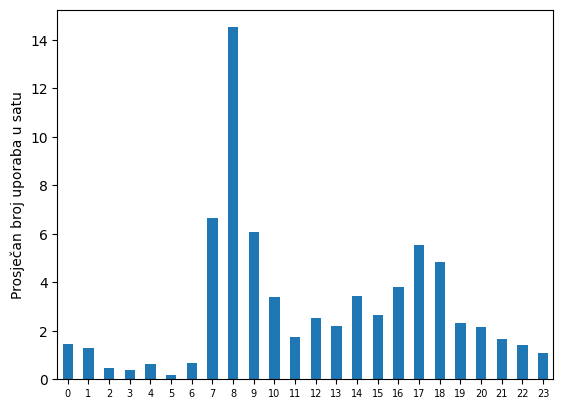

In [126]:
_ = plot_hourly_changes_bar(hourly.loc[station], changes_type = "out")

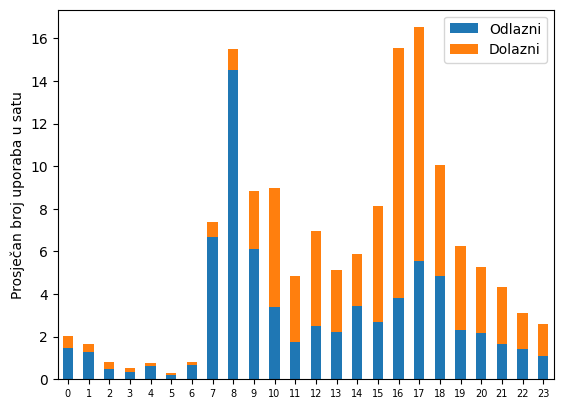

In [127]:
_ = plot_hourly_changes_bar(hourly.loc[station], changes_type = "in/out")

## Usage by day of week

In [128]:
daily = create_weekday_df(bike_data)
daily.head()

changes  incoming  outgoing
uid       wday                             
556632908 0         3.5      2.25      1.25
          1         5.2      2.80      2.40
          2         5.8      3.80      2.00
          3         5.8      3.40      2.40
          4         7.0      3.00      4.00

In [129]:
daily.groupby(["wday"]).sum()

,changes,incoming,outgoing
wday,,,
0,4457.25,2227.25,2230.0
1,3545.00,1776.70,1768.3
2,5335.70,2665.20,2670.5
3,4484.00,2250.10,2233.9
4,4808.00,2396.40,2411.6
5,2825.75,1419.05,1406.7
6,3406.75,1703.25,1703.5


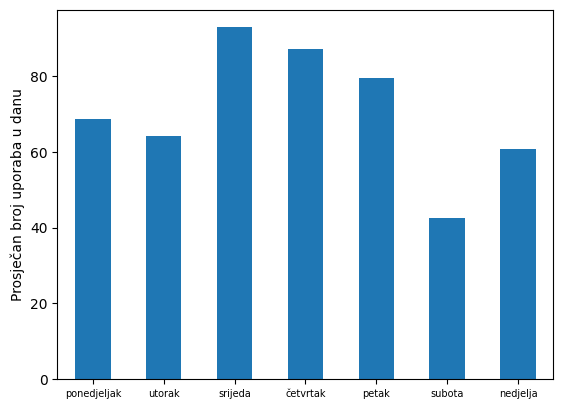

In [130]:
daily_plot = plot_weekday_bar(daily.loc[station])

'\n    \n    '
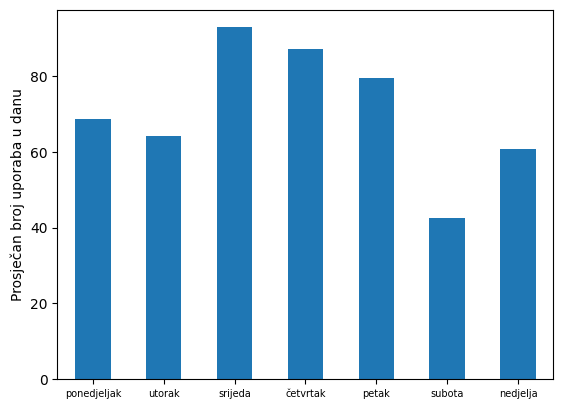

In [131]:
stringify_plot(daily_plot.get_figure())

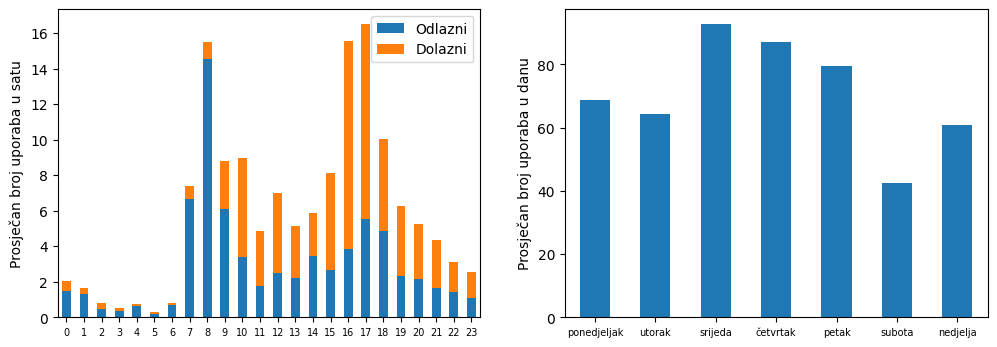

In [132]:
combined_plot_daily_weekly(hourly.loc[station],daily.loc[station])[0]

In [133]:
fig = folium.Figure(width = 1100, height = 500)

m = folium.Map(
    location=(45.8109, 16.0097),
    min_zoom=11,
    tiles = "Esri.WorldTopoMap"
)

fig.add_child(m)

circles = populate_map_with_stations(m,
                               locations_changes, 
                               metric_size = "total_changes", 
                               metric_tooltip_name = "Ukupno korištenja bicikala: ",
                               no_bins = 12)



In [134]:
CREATE_IMAGES = False

# Add a popup to each Circle
# temporarily, the same image for all stations

# set to false to speed up when working on notebook
if CREATE_IMAGES:
    for i in range(len(circles)):
        circ = circles[i]

        station_uid = locations_changes["uid"].iloc[i]

        circ.add_child(folium.Popup(stringify_plot(
            combined_plot_daily_weekly(hourly.loc[station_uid], daily.loc[station_uid])[0]
            )))

    _ = [circ.add_to(m) for circ in circles]

In [135]:
m

## Population
How many bikes at certain times vs. number of bike racks

In [136]:
# Info o broju bicikala naspram broju mjesta u svakom trenutku
population_data = create_population_columns(locations, bike_data)
population_data.tail()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop
134330,591300427,2025-12-13 23:12:20,"[801737, 801702, 801263, 801185, 801175, 80094...",2025-12-13 22:12:26,"[801737, 801263, 801185, 801175, 800946, 800859]",1.0,1.0,0.0,23,2025-12-13,5,7,NaN
134331,591300997,2025-12-13 23:12:20,"[801492, 801082, 801047, 800626]",2025-12-13 22:12:26,"[801492, 801082, 801047, 800626]",0.0,0.0,0.0,23,2025-12-13,5,4,NaN
134332,591301317,2025-12-13 23:12:20,"[800294, 800082, 800066, 801985, 801594, 80157...",2025-12-13 22:12:26,"[800368, 800294, 800082, 800066, 801985, 80159...",2.0,0.0,2.0,23,2025-12-13,5,13,NaN
134333,591302073,2025-12-13 23:12:20,"[800379, 800303, 801270, 801239, 801125, 80111...",2025-12-13 22:12:26,"[800379, 800303, 801270, 801239, 801125, 80111...",1.0,1.0,0.0,23,2025-12-13,5,8,NaN
134334,591302625,2025-12-13 23:12:20,"[800292, 801745, 801436, 801123, 800962, 800551]",2025-12-13 22:12:26,"[800292, 801745, 801436, 801123, 800962, 800551]",0.0,0.0,0.0,23,2025-12-13,5,6,NaN


In [137]:
# calculate occurences of interesting thresholds
population_data["out_of_bikes"] = population_data["population_prop"] == 0
population_data["low_on_bikes"] = population_data["population_prop"] <= 0.10

population_data["over_bike_capacity"] = population_data["population_prop"] > 1
population_data["greatly_over_bike_capacity"] = population_data["population_prop"] >= 1.2

population_data.tail()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
134330,591300427,2025-12-13 23:12:20,"[801737, 801702, 801263, 801185, 801175, 80094...",2025-12-13 22:12:26,"[801737, 801263, 801185, 801175, 800946, 800859]",1.0,1.0,0.0,23,2025-12-13,5,7,NaN,False,False,False,False
134331,591300997,2025-12-13 23:12:20,"[801492, 801082, 801047, 800626]",2025-12-13 22:12:26,"[801492, 801082, 801047, 800626]",0.0,0.0,0.0,23,2025-12-13,5,4,NaN,False,False,False,False
134332,591301317,2025-12-13 23:12:20,"[800294, 800082, 800066, 801985, 801594, 80157...",2025-12-13 22:12:26,"[800368, 800294, 800082, 800066, 801985, 80159...",2.0,0.0,2.0,23,2025-12-13,5,13,NaN,False,False,False,False
134333,591302073,2025-12-13 23:12:20,"[800379, 800303, 801270, 801239, 801125, 80111...",2025-12-13 22:12:26,"[800379, 800303, 801270, 801239, 801125, 80111...",1.0,1.0,0.0,23,2025-12-13,5,8,NaN,False,False,False,False
134334,591302625,2025-12-13 23:12:20,"[800292, 801745, 801436, 801123, 800962, 800551]",2025-12-13 22:12:26,"[800292, 801745, 801436, 801123, 800962, 800551]",0.0,0.0,0.0,23,2025-12-13,5,6,NaN,False,False,False,False


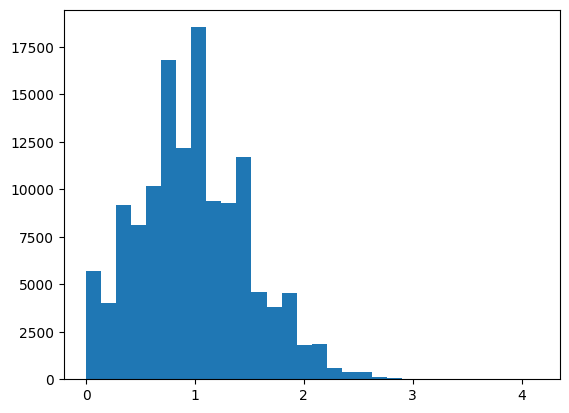

In [138]:
_ = plt.hist(population_data["population_prop"], bins = 30)

In [139]:
# For each DAY, count no. of each occurence for each station
df = population_data

df["date"] = df["time"].dt.date

daily = df.groupby(["uid", "date"]).agg({
    "out_of_bikes": "sum",
    "low_on_bikes": "sum",
    "over_bike_capacity": "sum",
    "greatly_over_bike_capacity": "sum"
})

daily


out_of_bikes  low_on_bikes  over_bike_capacity  \
uid       date                                                         
556632908 2025-11-11             0             0                   0   
          2025-11-12             0             0                   0   
          2025-11-13             0             0                   0   
          2025-11-14             0             0                   7   
          2025-11-15             0             0                  24   
...                            ...           ...                 ...   
591302625 2025-12-09             0             0                   0   
          2025-12-10             0             0                   0   
          2025-12-11             0             0                   0   
          2025-12-12             0             0                   0   
          2025-12-13             0             0                   0   

                      greatly_over_bike_capacity  
uid       date                                    
556632908 2025-11-11                           0  
          2025-11-12                           0  
          2025-11-13                           0  
          2025-11-14                           0  
          2025-11-15                          16  
...                                          ...  
591302625 2025-12-09                           0  
          2025-12-10                           0  
          2025-12-11                           0  
          2025-12-12                           0  
          2025-12-13                           0  

[5611 rows x 4 columns]

In [140]:
daily.index.get_level_values("uid").unique()

Index(['556632908', '556633495', '556634009', '556637365', '556689563',
       '556690758', '556693399', '556693838', '556694282', '556694696',
       ...
       '591297515', '591298537', '591298813', '591299513', '591300040',
       '591300427', '591300997', '591301317', '591302073', '591302625'],
      dtype='object', name='uid', length=179)

In [141]:
daily.groupby("uid").agg({
    "out_of_bikes": "mean",
    "low_on_bikes": "mean",
    "over_bike_capacity": "mean",
    "greatly_over_bike_capacity": "mean"
}).reset_index()

,uid,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,0.000000,0.000000,11.939394,10.515152
1,556633495,0.424242,0.575758,2.212121,0.212121
2,556634009,0.727273,1.575758,9.242424,7.818182
3,556637365,0.000000,0.121212,5.121212,3.393939
4,556689563,0.060606,0.757576,2.515152,0.909091
...,...,...,...,...,...
174,591300427,0.000000,0.000000,0.000000,0.000000
175,591300997,0.000000,0.000000,0.000000,0.000000
176,591301317,0.000000,0.000000,0.000000,0.000000
177,591302073,0.000000,0.000000,0.000000,0.000000


In [142]:
locations["uid"]

0      556632908
1      556633495
2      556634009
3      556637365
4      556689563
         ...    
164    585913605
165    585913702
166    586256300
167    586273004
168    587422590
Name: uid, Length: 169, dtype: object

In [143]:
# Calculate daily average for each station, with other station info


station_population = daily.groupby("uid").agg({
    "out_of_bikes": "mean",
    "low_on_bikes": "mean",
    "over_bike_capacity": "mean",
    "greatly_over_bike_capacity": "mean"
}).reset_index()


station_population

,uid,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,0.000000,0.000000,11.939394,10.515152
1,556633495,0.424242,0.575758,2.212121,0.212121
2,556634009,0.727273,1.575758,9.242424,7.818182
3,556637365,0.000000,0.121212,5.121212,3.393939
4,556689563,0.060606,0.757576,2.515152,0.909091
...,...,...,...,...,...
174,591300427,0.000000,0.000000,0.000000,0.000000
175,591300997,0.000000,0.000000,0.000000,0.000000
176,591301317,0.000000,0.000000,0.000000,0.000000
177,591302073,0.000000,0.000000,0.000000,0.000000


In [144]:
station_population = pd.merge(locations, station_population)
station_population

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,AUTOBUSNI TERMINAL SESVETE,45.825299,16.109747,8,0.000000,0.000000,11.939394,10.515152
1,556633495,MIHALJEVAC OKRETIŠTE,45.842797,15.975421,12,0.424242,0.575758,2.212121,0.212121
2,556634009,ROTOR REMETINEC,45.776795,15.953339,10,0.727273,1.575758,9.242424,7.818182
3,556637365,ADMIRAL HOTEL,45.795083,15.919185,20,0.000000,0.121212,5.121212,3.393939
4,556689563,ZAGREBAČKI VELESAJAM,45.777560,15.969703,20,0.060606,0.757576,2.515152,0.909091
...,...,...,...,...,...,...,...,...,...
164,585913605,PETROVA UL. - UL. IVANA ZAJCA,45.817526,15.997421,10,0.878788,2.030303,3.424242,1.515152
165,585913702,KORANSKA UL.,45.802365,15.968013,10,3.454545,5.757576,1.242424,0.393939
166,586256300,GAJNICE UL. - GRINTAVEČKA UL.,45.816342,15.872686,10,0.000000,0.000000,12.575758,10.878788
167,586273004,UL. V. VARIĆAKA 12,45.765589,15.988426,10,0.000000,0.000000,13.787879,11.333333


In [145]:
station_population.sort_values("out_of_bikes", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
62,579364575,KBC REBRO,45.823120,16.008103,16,5.121212,7.303030,1.454545,0.818182
162,585912890,PERKOVČEVA UL.,45.807631,15.968422,10,5.090909,6.454545,1.333333,1.000000
165,585913702,KORANSKA UL.,45.802365,15.968013,10,3.454545,5.757576,1.242424,0.393939
82,579368063,UL. GRADA VUKOVARA 52,45.799220,15.963448,10,3.363636,5.636364,6.424242,5.515152
163,585913527,GUPČEVA ZVIJEZDA,45.827987,15.979160,10,3.181818,5.878788,2.303030,2.212121


In [146]:
station_population.sort_values("low_on_bikes", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
62,579364575,KBC REBRO,45.823120,16.008103,16,5.121212,7.303030,1.454545,0.818182
53,579362036,SREDNJA ŠKOLA JELKOVEC,45.811709,16.106626,10,1.181818,6.484848,1.272727,0.484848
162,585912890,PERKOVČEVA UL.,45.807631,15.968422,10,5.090909,6.454545,1.333333,1.000000
163,585913527,GUPČEVA ZVIJEZDA,45.827987,15.979160,10,3.181818,5.878788,2.303030,2.212121
165,585913702,KORANSKA UL.,45.802365,15.968013,10,3.454545,5.757576,1.242424,0.393939


In [147]:
station_population.sort_values("over_bike_capacity", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
78,579367560,OSNOVNA ŠKOLA MALEŠNICA,45.808108,15.901237,10,0.0,0.0,23.696970,23.454545
141,583393028,UL. A. ŠOLJANA - OKRETIŠTE,45.802253,15.889798,10,0.0,0.0,23.606061,23.000000
114,583381755,UL. MILKE TRNINE,45.793229,16.005071,10,0.0,0.0,22.545455,21.272727
48,579359574,KULTURNI CENTAR DUBRAVA,45.829502,16.054064,10,0.0,0.0,22.212121,21.242424
69,579365500,OKTOGON DUGAVE,45.765985,15.992550,10,0.0,0.0,21.787879,17.848485


In [148]:
station_population.sort_values("greatly_over_bike_capacity", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
78,579367560,OSNOVNA ŠKOLA MALEŠNICA,45.808108,15.901237,10,0.0,0.0,23.696970,23.454545
141,583393028,UL. A. ŠOLJANA - OKRETIŠTE,45.802253,15.889798,10,0.0,0.0,23.606061,23.000000
114,583381755,UL. MILKE TRNINE,45.793229,16.005071,10,0.0,0.0,22.545455,21.272727
48,579359574,KULTURNI CENTAR DUBRAVA,45.829502,16.054064,10,0.0,0.0,22.212121,21.242424
140,583392895,UL. S.ALIĆA - UL. S.DRAGANIĆA,45.807223,15.896030,6,0.0,0.0,21.606061,20.333333


In [149]:
station_population.sort_values("low_on_bikes", ascending = False).head()

,uid,name,lat,lng,no_racks,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
62,579364575,KBC REBRO,45.823120,16.008103,16,5.121212,7.303030,1.454545,0.818182
53,579362036,SREDNJA ŠKOLA JELKOVEC,45.811709,16.106626,10,1.181818,6.484848,1.272727,0.484848
162,585912890,PERKOVČEVA UL.,45.807631,15.968422,10,5.090909,6.454545,1.333333,1.000000
163,585913527,GUPČEVA ZVIJEZDA,45.827987,15.979160,10,3.181818,5.878788,2.303030,2.212121
165,585913702,KORANSKA UL.,45.802365,15.968013,10,3.454545,5.757576,1.242424,0.393939


In [150]:
create_hourly_df(population_data.drop(["wday", "no_bikes"], axis = 1))

changes  incoming  outgoing  population_prop  out_of_bikes  \
uid       hour                                                               
556632908 0         0.0       0.0       0.0         1.195312           0.0   
          1         0.0       0.0       0.0         1.178030           0.0   
          2         0.0       0.0       0.0         1.178030           0.0   
          3         0.0       0.0       0.0         1.178030           0.0   
          4         0.0       0.0       0.0         1.178030           0.0   
...                 ...       ...       ...              ...           ...   
591300997 19        0.0       0.0       0.0         0.000000           0.0   
          20        0.0       0.0       0.0         0.000000           0.0   
          21        0.0       0.0       0.0         0.000000           0.0   
          22        0.0       0.0       0.0         0.000000           0.0   
          23        0.0       0.0       0.0         0.000000           0.0   

                low_on_bikes  over_bike_capacity  greatly_over_bike_capacity  
uid       hour                                                                
556632908 0              0.0            0.500000                    0.437500  
          1              0.0            0.484848                    0.424242  
          2              0.0            0.484848                    0.424242  
          3              0.0            0.484848                    0.424242  
          4              0.0            0.484848                    0.424242  
...                      ...                 ...                         ...  
591300997 19             0.0            0.000000                    0.000000  
          20             0.0            0.000000                    0.000000  
          21             0.0            0.000000                    0.000000  
          22             0.0            0.000000                    0.000000  
          23             0.0            0.000000                    0.000000  

[4296 rows x 8 columns]

In [151]:
all_stations_pop = population_data.groupby(["time"]).mean(["population_prop"])
all_stations_pop.head()

,changes,incoming,outgoing,hour,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
time,,,,,,,,,,,
2025-11-11 01:15:08,0.327273,0.175758,0.151515,1.0,1.0,11.551515,1.009339,0.036364,0.066667,0.436364,0.375758
2025-11-11 02:13:15,0.078788,0.048485,0.030303,2.0,1.0,11.569697,1.010399,0.030303,0.072727,0.436364,0.375758
2025-11-11 03:05:07,0.012121,0.006061,0.006061,3.0,1.0,11.569697,1.010197,0.030303,0.072727,0.436364,0.375758
2025-11-11 04:17:33,0.054545,0.030303,0.024242,4.0,1.0,11.575758,1.010703,0.030303,0.072727,0.436364,0.375758
2025-11-11 05:00:29,0.006061,0.000000,0.006061,5.0,1.0,11.569697,1.010096,0.030303,0.072727,0.436364,0.375758


{'whiskers': [<matplotlib.lines.Line2D at 0x1ea35defed0>,
 'caps': [<matplotlib.lines.Line2D at 0x1ea35defd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ea35def890>],
 'medians': [<matplotlib.lines.Line2D at 0x1ea383007d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ea38300910>],
 'means': []}

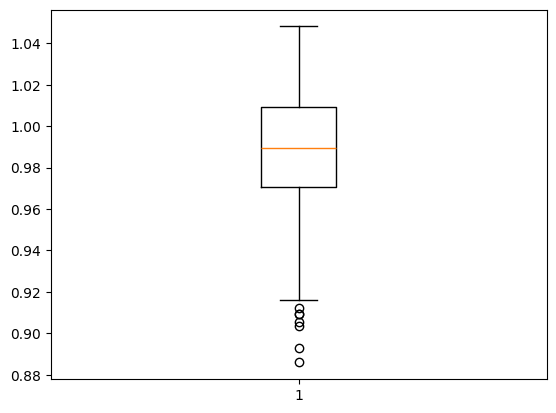

In [152]:
plt.boxplot(all_stations_pop["population_prop"])

In [153]:
tkt_uid = locations[locations["name"] == "FILOZOFSKI FAKULTET"]["uid"].to_list()[0]

tkt_population = population_data[population_data["uid"] == tkt_uid]

tkt_population.head()


,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
58,579364165,2025-11-11 01:15:08,[],2025-11-11 00:01:43,[],0.0,0.0,0.0,1,2025-11-11,1,0,0.00,True,True,False,False
223,579364165,2025-11-11 02:13:15,[800375],2025-11-11 01:15:08,[],1.0,1.0,0.0,2,2025-11-11,1,1,0.05,False,True,False,False
388,579364165,2025-11-11 03:05:07,[800375],2025-11-11 02:13:15,[800375],0.0,0.0,0.0,3,2025-11-11,1,1,0.05,False,True,False,False
553,579364165,2025-11-11 04:17:33,[800375],2025-11-11 03:05:07,[800375],0.0,0.0,0.0,4,2025-11-11,1,1,0.05,False,True,False,False
718,579364165,2025-11-11 05:00:29,[800375],2025-11-11 04:17:33,[800375],0.0,0.0,0.0,5,2025-11-11,1,1,0.05,False,True,False,False


{'whiskers': [<matplotlib.lines.Line2D at 0x1ea36116c10>,
 'caps': [<matplotlib.lines.Line2D at 0x1ea36116e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ea36116ad0>],
 'medians': [<matplotlib.lines.Line2D at 0x1ea36117110>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ea36117250>],
 'means': []}

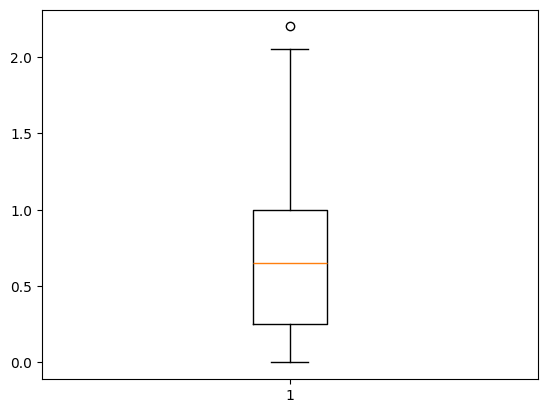

In [154]:
plt.boxplot(tkt_population["population_prop"])

Za interpretaciju:  
ispod crte u boxu je 50% rezultata, od crte do donjeg kraja boxa je 25% rezultata.

Idealna distribucija je gdje je medijan negdje ispod 100% - uvijek je dostupan velik broj bicikala, kao i par mjesta za ostaviti bickle.
Ako se kutija proteže znatno iznad 1.0, znači da je česta situacija gdje je na postaji ostavljeno više bicikala od dostupnog broja mjesta.
Povećanje broja dostupnih mjesta bi popravilo tu situaciju.


-> dodati postotak opaženih vremena u kojima je prisutno 0 bicikala - prevelika navala, netko tko bi htio koristiti bajs ne može!
--> bolje: dodati tablicu s deset postaja u kojima je dnevna incidencija 0 dostupnih bicikala najveća. Konkretan broj opaženih situacija ovisi o učestalosti mjerenja, ali postaje gdje je taj broj najveći su one gdje je to najčešći problem, neovisno o učestalosti mjerenja.


In [155]:
# boxplot paralelno za 3 postaje koje imaju najviši, pa 3 s najnižim mean population -- za sve vremenske točke, bez agregiranja

In [156]:
stations_pop = population_data.groupby(["uid"]).median(["population_prop"]).sort_values("population_prop", ascending = False)

pop_high = stations_pop.head(3)
pop_low = stations_pop.tail(3)

pop_high

,changes,incoming,outgoing,hour,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
uid,,,,,,,,,,,
583392895,0.0,0.0,0.0,12.0,3.0,11.0,1.833333,0.0,0.0,1.0,1.0
579359574,0.0,0.0,0.0,12.0,3.0,16.0,1.600000,0.0,0.0,1.0,1.0
579367560,0.0,0.0,0.0,12.0,3.0,16.0,1.600000,0.0,0.0,1.0,1.0


In [157]:
pop_low

,changes,incoming,outgoing,hour,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
uid,,,,,,,,,,,
591301317,0.0,0.0,0.0,13.0,4.0,11.5,NaN,0.0,0.0,0.0,0.0
591302073,0.0,0.0,0.0,13.0,4.0,8.0,NaN,0.0,0.0,0.0,0.0
591302625,0.0,0.0,0.0,13.0,3.0,4.0,NaN,0.0,0.0,0.0,0.0


In [158]:
uid_high = pop_high.index.to_list()
uid_low = pop_low.index.to_list()
uids = uid_high + uid_low
uids

['583392895', '579359574', '579367560', '591301317', '591302073', '591302625']

In [159]:
plot_data = population_data[population_data["uid"].isin(uids)].merge(locations, on = "uid")

# proporcije u postotke
plot_data["population_prop"] *= 100
plot_data.head()

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,...,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity,name,lat,lng,no_racks
0,579359574,2025-11-11 01:15:08,"[800487, 800453, 800408, 800388, 800263, 80022...",2025-11-11 00:01:43,"[800487, 800453, 800408, 800388, 800263, 80022...",0.0,0.0,0.0,1,2025-11-11,...,22,220.000000,False,False,True,True,KULTURNI CENTAR DUBRAVA,45.829502,16.054064,10
1,579367560,2025-11-11 01:15:08,"[800417, 800415, 800383, 800273, 800167, 80004...",2025-11-11 00:01:43,"[800417, 800415, 800383, 800273, 800167, 80004...",0.0,0.0,0.0,1,2025-11-11,...,13,130.000000,False,False,True,True,OSNOVNA ŠKOLA MALEŠNICA,45.808108,15.901237,10
2,583392895,2025-11-11 01:15:08,"[800374, 800341, 801623, 801591, 801442, 80133...",2025-11-11 00:01:43,"[800374, 800341, 801623, 801591, 801442, 80133...",0.0,0.0,0.0,1,2025-11-11,...,11,183.333333,False,False,True,True,UL. S.ALIĆA - UL. S.DRAGANIĆA,45.807223,15.896030,6
3,579359574,2025-11-11 02:13:15,"[800487, 800453, 800408, 800388, 800263, 80022...",2025-11-11 01:15:08,"[800487, 800453, 800408, 800388, 800263, 80022...",0.0,0.0,0.0,2,2025-11-11,...,22,220.000000,False,False,True,True,KULTURNI CENTAR DUBRAVA,45.829502,16.054064,10
4,579367560,2025-11-11 02:13:15,"[800417, 800415, 800383, 800273, 800167, 80004...",2025-11-11 01:15:08,"[800417, 800415, 800383, 800273, 800167, 80004...",0.0,0.0,0.0,2,2025-11-11,...,13,130.000000,False,False,True,True,OSNOVNA ŠKOLA MALEŠNICA,45.808108,15.901237,10


In [160]:
uids

['583392895', '579359574', '579367560', '591301317', '591302073', '591302625']

In [161]:
order_names = locations[locations["uid"].isin(uids)]

order_names = order_names.set_index("uid").reindex(uids)["name"].to_list()
order_names

['UL. S.ALIĆA - UL. S.DRAGANIĆA',
 'KULTURNI CENTAR DUBRAVA',
 'OSNOVNA ŠKOLA MALEŠNICA',
 nan,
 nan,
 nan]

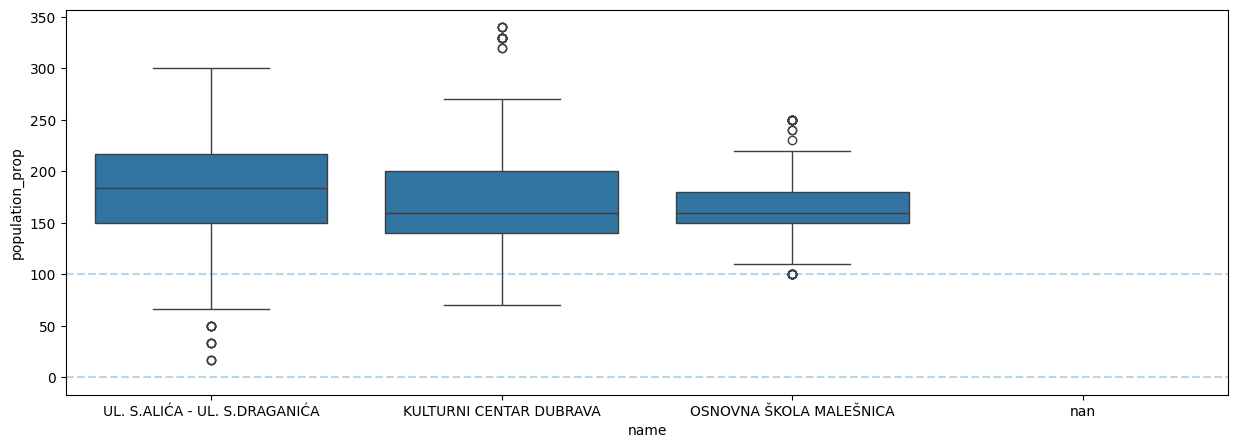

In [162]:
plt.figure(figsize=(15,5))

ax = sns.boxplot(data = plot_data, y = "population_prop", x = "name", order = order_names)

# referentne crte za 0% i 100%
_ = ax.axhline(0, ls="--", alpha = 0.3)
_ = ax.axhline(100, ls="--", alpha = 0.3)

In [163]:
population_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,2025-11-11 01:15:08,"[800463, 800020, 801638, 801088, 800886]",2025-11-11 00:01:43,"[800463, 800020, 801638, 801088, 800886]",0.0,0.0,0.0,1,2025-11-11,1,5,0.625,False,False,False,False
1,556633495,2025-11-11 01:15:08,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-11 00:01:43,"[800480, 800247, 800185, 800183, 800106, 80005...",0.0,0.0,0.0,1,2025-11-11,1,9,0.750,False,False,False,False
2,556634009,2025-11-11 01:15:08,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-11 00:01:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2.0,0.0,2.0,1,2025-11-11,1,17,1.700,False,False,True,True
3,556637365,2025-11-11 01:15:08,"[800428, 801920, 801915, 801881, 801745, 80164...",2025-11-11 00:01:43,"[800428, 801920, 801915, 801881, 801745, 80164...",0.0,0.0,0.0,1,2025-11-11,1,16,0.800,False,False,False,False
4,556689563,2025-11-11 01:15:08,"[800223, 801846, 801666, 801548, 801347, 80128...",2025-11-11 00:01:43,"[801846, 801666, 801548, 801347, 801283, 80100...",1.0,1.0,0.0,1,2025-11-11,1,11,0.550,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134330,591300427,2025-12-13 23:12:20,"[801737, 801702, 801263, 801185, 801175, 80094...",2025-12-13 22:12:26,"[801737, 801263, 801185, 801175, 800946, 800859]",1.0,1.0,0.0,23,2025-12-13,5,7,NaN,False,False,False,False
134331,591300997,2025-12-13 23:12:20,"[801492, 801082, 801047, 800626]",2025-12-13 22:12:26,"[801492, 801082, 801047, 800626]",0.0,0.0,0.0,23,2025-12-13,5,4,NaN,False,False,False,False
134332,591301317,2025-12-13 23:12:20,"[800294, 800082, 800066, 801985, 801594, 80157...",2025-12-13 22:12:26,"[800368, 800294, 800082, 800066, 801985, 80159...",2.0,0.0,2.0,23,2025-12-13,5,13,NaN,False,False,False,False
134333,591302073,2025-12-13 23:12:20,"[800379, 800303, 801270, 801239, 801125, 80111...",2025-12-13 22:12:26,"[800379, 800303, 801270, 801239, 801125, 80111...",1.0,1.0,0.0,23,2025-12-13,5,8,NaN,False,False,False,False


In [164]:
top_5_stations = get_population_extremes(population_data, n_top = 5, n_bottom = 0)
top_5_stations

['583392895', '579359574', '579367560', '579364727', '583381755']

DATA OK
Initial boxplot OK
['UL. S.ALIĆA - UL. S.DRAGANIĆA', 'KULTURNI CENTAR DUBRAVA', 'OSNOVNA ŠKOLA MALEŠNICA', 'UL. JORDANOVAC', 'UL. MILKE TRNINE']


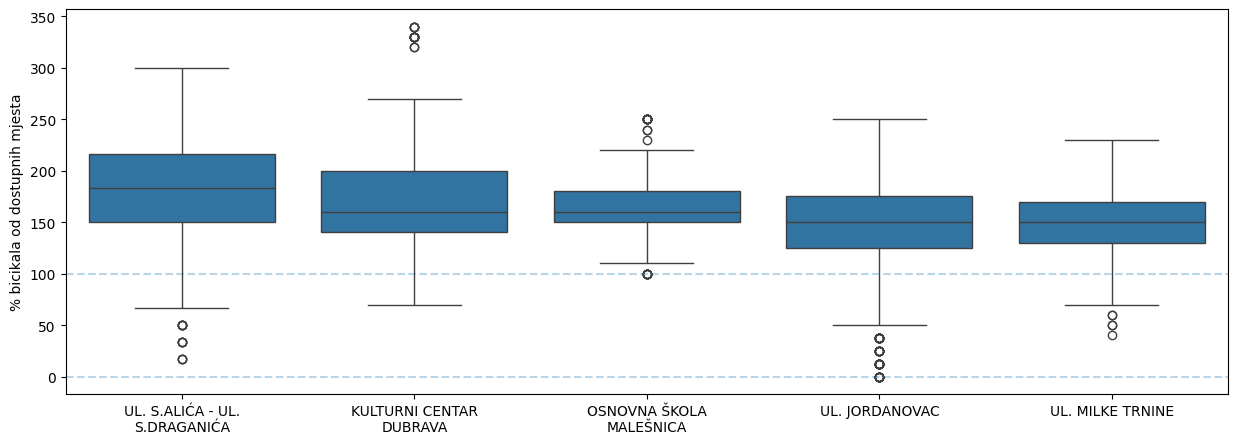

In [165]:
plt.figure(figsize=(15,5))
_ = station_population_boxplots(population_data, locations, top_5_stations)

In [166]:
population_data

,uid,time,bikes_at_station,lag1_time,bikes_at_station_lag1,changes,incoming,outgoing,hour,date,wday,no_bikes,population_prop,out_of_bikes,low_on_bikes,over_bike_capacity,greatly_over_bike_capacity
0,556632908,2025-11-11 01:15:08,"[800463, 800020, 801638, 801088, 800886]",2025-11-11 00:01:43,"[800463, 800020, 801638, 801088, 800886]",0.0,0.0,0.0,1,2025-11-11,1,5,0.625,False,False,False,False
1,556633495,2025-11-11 01:15:08,"[800480, 800247, 800185, 800183, 800106, 80005...",2025-11-11 00:01:43,"[800480, 800247, 800185, 800183, 800106, 80005...",0.0,0.0,0.0,1,2025-11-11,1,9,0.750,False,False,False,False
2,556634009,2025-11-11 01:15:08,"[800220, 800201, 800129, 800079, 801995, 80188...",2025-11-11 00:01:43,"[800220, 800201, 800129, 800079, 801995, 80188...",2.0,0.0,2.0,1,2025-11-11,1,17,1.700,False,False,True,True
3,556637365,2025-11-11 01:15:08,"[800428, 801920, 801915, 801881, 801745, 80164...",2025-11-11 00:01:43,"[800428, 801920, 801915, 801881, 801745, 80164...",0.0,0.0,0.0,1,2025-11-11,1,16,0.800,False,False,False,False
4,556689563,2025-11-11 01:15:08,"[800223, 801846, 801666, 801548, 801347, 80128...",2025-11-11 00:01:43,"[801846, 801666, 801548, 801347, 801283, 80100...",1.0,1.0,0.0,1,2025-11-11,1,11,0.550,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134330,591300427,2025-12-13 23:12:20,"[801737, 801702, 801263, 801185, 801175, 80094...",2025-12-13 22:12:26,"[801737, 801263, 801185, 801175, 800946, 800859]",1.0,1.0,0.0,23,2025-12-13,5,7,NaN,False,False,False,False
134331,591300997,2025-12-13 23:12:20,"[801492, 801082, 801047, 800626]",2025-12-13 22:12:26,"[801492, 801082, 801047, 800626]",0.0,0.0,0.0,23,2025-12-13,5,4,NaN,False,False,False,False
134332,591301317,2025-12-13 23:12:20,"[800294, 800082, 800066, 801985, 801594, 80157...",2025-12-13 22:12:26,"[800368, 800294, 800082, 800066, 801985, 80159...",2.0,0.0,2.0,23,2025-12-13,5,13,NaN,False,False,False,False
134333,591302073,2025-12-13 23:12:20,"[800379, 800303, 801270, 801239, 801125, 80111...",2025-12-13 22:12:26,"[800379, 800303, 801270, 801239, 801125, 80111...",1.0,1.0,0.0,23,2025-12-13,5,8,NaN,False,False,False,False


In [173]:
locations[locations["name"] == "JU\u017dNA ULICA - BRANIMIROVA UL."]

,uid,name,lat,lng,no_racks


In [167]:
bottom_6_stations

['591300040', '591300427', '591300997', '591301317', '591302073', '591302625']

In [168]:
locations[locations["uid"].isin(bottom_6_stations)]

,uid,name,lat,lng,no_racks


In [169]:
locations_first[locations_first["uid"].isin(bottom_6_stations)]

,uid,name,lat,lng,no_racks


In [170]:
bottom_6_stations = get_population_extremes(population_data, n_top = 0, n_bottom = 6)
plt.figure(figsize=(15,5))
_ = station_population_boxplots(population_data, locations, bottom_6_stations, text_wrap_chars = 15)

DATA OK
Initial boxplot OK
[nan, nan, nan, nan, nan, nan]


AttributeError: 'float' object has no attribute 'expandtabs'

Error in callback <function _draw_all_if_interactive at 0x000001EA30148FE0> (for post_execute), with arguments args (),kwargs {}:


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 1500x500 with 1 Axes>

In [ ]:
mg_uid = locations[locations["name"] == "MIROGOJ"]["uid"].to_list()
mg_uid

['583376002']

<Axes: xlabel='population_prop', ylabel='Count'>

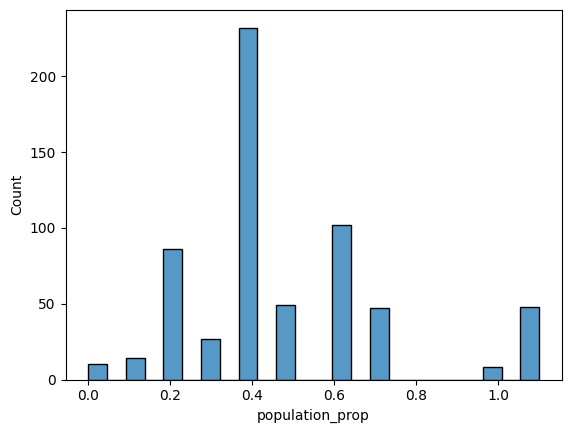

In [ ]:
mg_population_data = population_data[population_data["uid"] == mg_uid[0]]

sns.histplot(mg_population_data["population_prop"])